# SciPy-数值计算库
SciPy函数库在NumPy库的基础上增加了众多的数学、科学以及工程计算中常用的库函数。例如线性 代数、常微分方程数值求解、信号处理、图像处理、稀疏矩阵等等。由于其涉及的领域众多、本书没 有能力对其一一的进行介绍。作为入门介绍，让我们看看如何用SciPy进行插值处理、信号滤波以及用 C语言加速计算。


真实参数: [10, 0.34, 0.5235987755982988]
拟合参数 [10.13559485  0.34164017  0.55909753]


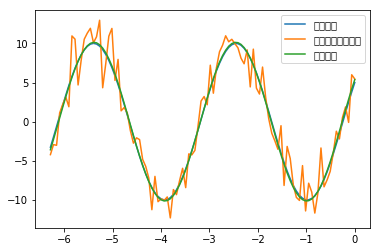

In [8]:
# 3.1 最小二乘拟合

%matplotlib inline
import numpy as np
from scipy.optimize import *
import pylab as pl
import scipy.optimize as opt
def func(x, p):
    """
    数据拟合所用的函数: A*sin(2*pi*k*x + theta) 
    """
    A, k, theta = p
    return A*np.sin(2*np.pi*k*x+theta)
def residuals(p, y, x):
    """
    实验数据x, y和拟合函数之间的差，p为拟合需要找到的系数 
    """
    return y - func(x, p)
x = np.linspace(0, -2*np.pi, 100)
A, k, theta = 10, 0.34, np.pi/6 # 真实数据的函数参数
y0 = func(x, [A, k, theta]) # 真实数据
y1 = y0 + 2 * np.random.randn(len(x)) # 加入噪声之后的实验数据
p0 = [7, 0.2, 0] # 第一次猜测的函数拟合参数
# 调用leastsq进行数据拟合
# residuals为计算误差的函数
# p0为拟合参数的初始值
# args为需要拟合的实验数据
plsq = leastsq(residuals, p0, args=(y1, x))
print(u"真实参数:", [A, k, theta])
print( u"拟合参数", plsq[0]) # 实验数据拟合后的参数
pl.plot(x, y0, label=u"真实数据")
pl.plot(x, y1, label=u"带噪声的实验数据") 
pl.plot(x, func(x, plsq[0]), label=u"拟合数据") 
pl.legend()
pl.show()

optimize库提供了几个求函数最小值的算法:fmin, fmin_powell, fmin_cg, fmin_bfgs。下面的程序 通过求解卷积的逆运算演示fmin的功能。


In [10]:
def test_fmin_convolve(fminfunc, x, h, y, yn, x0):
    """
    x (*) h = y,(*)表示卷积 
    yn为在y的基础上添加一些干扰噪声的结果 x0为求解x的初始值
    """
    def convolve_func(h):
        """
        计算 yn - x (*) h 的power 
        fmin将通过计算使得此power最小
        """
        return np.sum((yn - np.convolve(x, h))**2)
    # 调用fmin函数，以x0为初始值
    h0 = fminfunc(convolve_func, x0)
    print (fminfunc.__name__)
    print ("---------------------")
    # 输出 x( (*) h0 和 y 之间的相对误差
    print ("error of y:", np.sum((np.convolve(x, h0)-y)**2)/np.sum(y**2))
    # 输出 h0 和 h 之间的相对误差
    print ("error of h:", np.sum((h0-h)**2)/np.sum(h**2))
    print()
def test_n(m, n, nscale):
    """
    随机产生x, h, y, yn, x0等数列，调用各种fmin函数求解b m为x的长度, n为h的长度, nscale为干扰的强度
    """
    x = np.random.rand(m)
    h = np.random.rand(n)
    y = np.convolve(x, h)
    yn = y + np.random.rand(len(y)) * nscale
    x0 = np.random.rand(n)
    test_fmin_convolve(opt.fmin, x, h, y, yn, x0)
    test_fmin_convolve(opt.fmin_powell, x, h, y, yn, x0)
    test_fmin_convolve(opt.fmin_cg, x, h, y, yn, x0)
    test_fmin_convolve(opt.fmin_bfgs, x, h, y, yn, x0)
if __name__ == "__main__":
    test_n(200, 20, 0.1)

fmin
---------------------
error of y: 0.004240254871705006
error of h: 0.24555643752433337

Optimization terminated successfully.
         Current function value: 0.205789
         Iterations: 41
         Function evaluations: 7681
fmin_powell
---------------------
error of y: 0.00012388997286038223
error of h: 0.00029820819463358296

Optimization terminated successfully.
         Current function value: 0.205782
         Iterations: 24
         Function evaluations: 1144
         Gradient evaluations: 52
fmin_cg
---------------------
error of y: 0.00012331514971611562
error of h: 0.0002974280368922337

Optimization terminated successfully.
         Current function value: 0.205782
         Iterations: 30
         Function evaluations: 946
         Gradient evaluations: 43
fmin_bfgs
---------------------
error of y: 0.00012331510876802958
error of h: 0.0002974270651253611



# 非线性方程组求解
![](http://ww4.sinaimg.cn/large/006tNc79gy1g55n73pkrnj30fq064gli.jpg)

In [11]:
from scipy.optimize import fsolve 
from math import sin,cos
def f(x):
    x0 = float(x[0])
    x1 = float(x[1])
    x2 = float(x[2])
    return [
        5*x1+3,
        4*x0*x0 - 2*sin(x1*x2),
        x1*x2 - 1.5
    ]
result = fsolve(f, [1,1,1])
print (result)
print (f(result))

[-0.70622057 -0.6        -2.5       ]
[0.0, -9.126033262418787e-14, 5.329070518200751e-15]


![](http://ww1.sinaimg.cn/large/006tNc79gy1g55n7kacu8j316i0d63z8.jpg)

# B-Spline样条曲线

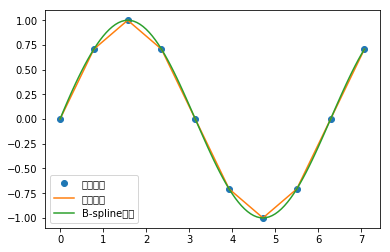

In [15]:
import numpy as np
import pylab as pl
from scipy import interpolate
x = np.linspace(0, 2*np.pi+np.pi/4, 10)
y = np.sin(x)
x_new = np.linspace(0, 2*np.pi+np.pi/4, 100)
f_linear = interpolate.interp1d(x, y)
tck = interpolate.splrep(x, y)
y_bspline = interpolate.splev(x_new, tck)
pl.plot(x, y, "o", label="原始数据") 
pl.plot(x_new, f_linear(x_new), label="线性插值") 
pl.plot(x_new, y_bspline, label="B-spline插值") 
pl.legend()
pl.show()

# 数值积分

In [18]:
# 单位半圆
def half_circle(x):
    return (1-x**2)**0.5
N = 10000
x = np.linspace(-1, 1, N)
dx = 2.0/N
y = half_circle(x)
dx * np.sum(y[:-1] + y[1:]) # 面积的两倍

3.1412751679989044

In [19]:
>>> import numpy as np
>>> np.trapz(y, x) * 2 

3.1415893269315975

In [20]:
>>> from scipy import integrate
>>> pi_half, err = integrate.quad(half_circle, -1, 1)
>>> pi_half*2

3.1415926535897967

![](http://ww1.sinaimg.cn/large/006tNc79gy1g55nb4xvi3j31800buwff.jpg)

In [27]:
def half_sphere(x, y):
    return (1-x**2-y**2)**0.5

integrate.dblquad(half_sphere, -1, 1,lambda x:-half_circle(x),lambda x:half_circle(x))
(2.0943951023931988, 2.3252456653390915e-14) 
np.pi*4/3/2 
# 通过球体体积公式计算的半球体积


2.0943951023931953

![](http://ww4.sinaimg.cn/large/006tNc79gy1g55nculebtj318q0rymyx.jpg)

# 解常微分方程组
![](http://ww4.sinaimg.cn/large/006tNc79gy1g55nf694plj318g0d23z4.jpg)

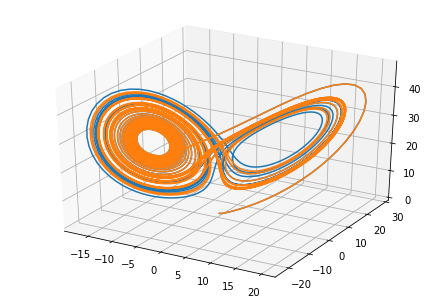

In [29]:
from scipy.integrate import odeint 
import numpy as np
def lorenz(w, t, p, r, b):
    # 给出位置矢量w，和三个参数p, r, b计算出
    # dx/dt, dy/dt, dz/dt的值
    x, y, z = w
    # 直接与lorenz的计算公式对应
    return np.array([p*(y-x), x*(r-z)-y, x*y-b*z])
t = np.arange(0, 30, 0.01) # 创建时间点
# 调用ode对lorenz进行求解, 用两个不同的初始值
track1 = odeint(lorenz, (0.0, 1.00, 0.0), t, args=(10.0, 28.0, 3.0)) 
track2 = odeint(lorenz, (0.0, 1.01, 0.0), t, args=(10.0, 28.0, 3.0))
# 绘图
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(track1[:,0], track1[:,1], track1[:,2])
ax.plot(track2[:,0], track2[:,1], track2[:,2])
plt.show()

In [34]:
# 嵌入 c++
import scipy.weave as weave 
import numpy as np
import time
def my_sum(a):
    n=int(len(a))
    code="""
    int i;
    double counter; counter =0; for(i=0;i<n;i++){
        counter=counter+a(i);
    }
    return_val=counter; 
    """
    err=weave.inline(
        code,['a','n'],
        type_converters=weave.converters.blitz,
        compiler="gcc"
    )
return err
a = np.arange(0, 10000000, 1.0)
# 先调用一次my_sum，weave会自动对C语言进行编译，此后直接运行编译之后的代码 my_sum(a)
start = time.clock()
for i in range(100):
    my_sum(a) # 直接运行编译之后的代码
print ("my_sum:", (time.clock() - start) / 100.0)
start = time.clock()

ModuleNotFoundError: No module named 'scipy.weave'